In [1]:
#importing modules - seaborn style is so we have no image issues with graphs

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mtick
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from uk_covid19 import Cov19API
import datetime
sns.set_style("white")

In [17]:
def plot_ensemble_graph(Number_of_Days, Location, Area_Type, start, end, tau, x, y):
    
    #incubation time of the disease
    inc_time = 5
    
    #creates an vector of zeros of the right size, will use later
    mean_vector = np.zeros(Number_of_Days)
    #creates a vector to store today's values from ech ensemble run
    today_vector = np.array([])
    
    #"target" is R = 1
    target = np.ones(len(mean_vector))

    #each loop is one "ensemble run", using trendlines over r_calc_length days
    for r_calc_length in np.arange(start,end):
        
        #define new variable to that allows us to get extract the right amount of data from API
        Cutoff = Number_of_Days + r_calc_length + 2

        #describing data we want from API
        area = [
            'areaType=' + Area_Type,
            'areaName=' + Location,
        ]

        data_type = {
            "date": "date",
            "newCasesByPublishDate": "newCasesByPublishDate",
        }

        #extracting data from API
        api = Cov19API(filters=area, structure=data_type)
        df = api.get_dataframe()

        #ignores 5 most recent days due to reporting lab
        Actual_Date = df.iloc[Cutoff:3:-1,0] #extracts relevant dates
        Date = dates.date2num(Actual_Date) #turns dates into numbers for calculation purposes
        Data = np.array(df.iloc[Cutoff:3:-1,1]) #extracts relevant data
   
        #calculates first value of R separately from the others
        rhist_vector = [] #creates an empty vector to store all the values for this ensemble run
        rhist_0_params = np.polyfit(Date[:r_calc_length],np.log(Data[:r_calc_length]), 1) #calculating exponential fit
        rhist_0_log_trend = Date * rhist_0_params[0] + rhist_0_params[1] #calculating exponential fit
        rhist_0_trend = np.exp(rhist_0_log_trend) #calculating exponential fit
        rhist_0 = (float(np.exp(rhist_0_params[0])))**(inc_time) #calculates R from exponential fit trendline
        rhist_vector.insert(0, rhist_0) #adds value to vector

        #fits parameters & calculates R over all other periods and adds it to vector
        for i in range(1, len(Date) - r_calc_length + 1):
            rhist_params = np.polyfit(Date[i : r_calc_length + i ],np.log(Data[i : r_calc_length + i ]), 1)
            rhist_log_trend = Date * rhist_params[0] + rhist_params[1]
            rhist_trend = np.exp(rhist_log_trend)
            rhist = (float(np.exp(rhist_params[0])))**(inc_time) 
            next_rhist = tau*rhist + (1-tau)*rhist_vector[-1] #creates new estimate using wt average of old + new R
            rhist_vector.insert(0, next_rhist) #adds value to vector

    
        #plot ensemble
        plt.title(Location +' R: Ensemble', fontsize = 16)
        plt.rcParams["figure.figsize"] = [x,y]
        plt.xlabel('Date', fontsize = 16)  
        plt.ylabel('R Number', fontsize = 14)
        plt.plot_date(Actual_Date[r_calc_length - 1:],rhist_vector[::-1],'c--')
        plt.plot_date(Actual_Date[r_calc_length - 1:],target,'k--')
        plt.xticks(rotation=45)
        
        #creates vector for ensemble mean
        today_vector = np.append(today_vector, rhist_vector[0])
        mean_vector = np.add(rhist_vector, mean_vector)
    
    #creates ensemble mean
    highest, lowest =  round(max(today_vector),2) , round(min(today_vector),2)
    mean_vector = mean_vector / (end-start) 
    todays_estimate = round(mean_vector[0],2) #Today's R value
    historical_lowest = round(min(mean_vector),2) #lowest R in the period we calculate over
    weeks_average = round(np.average(mean_vector[:7]), 2) #calculates average over the last week
    print("Today's R estimate is: " + str(todays_estimate) + " (" + str(lowest) + " - " + str(highest) + ")")
    print("Lowest in the period is: " + str(historical_lowest))
    print("Average over the last week is: " + str(weeks_average))
    
    #smooths the ensemble vector
    smoothed_vector = []
    for i in range(len(mean_vector) - 7):
        smoothed_vector = np.append(smoothed_vector,np.average(mean_vector[i:7+i]))        
    
    #shows ensemble plot
    ensemble_mean, = plt.plot(Actual_Date[r_calc_length - 1:],mean_vector[::-1],'r-', linewidth=3)
    plt.legend([ensemble_mean],['Ensemble Mean'])
    plt.show()

#     #Create spline curve - am still working on this to make the curve smoother 
#     int_Date = np.array([ int(x) for x in Date ])
#     int_Date_rr = np.arange(int_Date.min() + r_calc_length - 2,int_Date.max())
#     spline = interp1d(int_Date_rr, mean_vector, kind='cubic', fill_value="extrapolate")
#     Date_detailed = np.arange(int_Date.min() + r_calc_length - 2,int_Date.max(), 0.1)
#     spline_target = np.ones(len(Date_detailed))

#     #Plot minimalist spline curve
#     plt.title(Location +' R', fontsize = 16)
#     plt.xlabel('Date', fontsize = 16)  
#     plt.ylabel('R Number', fontsize = 14)
#     plt.plot(dates.num2date(Date_detailed[::-1], tz = None),spline(Date_detailed),'r-')
#     plt.plot(dates.num2date(Date_detailed[::-1], tz = None),spline_target,'k--')

    #creates the figure to plot
    months = dates.MonthLocator()
    fig,ax1 = plt.subplots()
    fig.set_size_inches(x,y) #sets size #rotates x axis
    dates.WeekdayLocator.MAXTICKS = 3000
    fig.autofmt_xdate(rotation=45) #rotates x axis

    #plots bar chart
    color_bar = 'gainsboro' 
    ax1.set_xlabel('Date', fontsize = 16) 
    ax1.set_ylabel('Cases', fontsize = 14, color='grey')
    ax1.bar(dates.num2date(Date[r_calc_length -1:]), Data[r_calc_length -1:], color=color_bar, width=1, align='center')
    ax1.tick_params(axis ='y', labelcolor='grey') 
    ax1.tick_params(axis = 'x', labelcolor= 'k')
    ax1.set_yscale('log')
    ax1.xaxis.set_minor_formatter(mtick.ScalarFormatter())

    #ax1.xaxis.set_major_locator(dates.WeekdayLocator())

    #adds another set of axes with the same x axis, but different y axis
    ax2 = ax1.twinx()

    #plots R
    color_r = 'r'
    ax1.set_title(Location +" R: Today's estimate is: " + str(weeks_average), fontsize = 16)
    ax2.set_xlabel('Date', fontsize = 16)  
    ax2.set_ylabel('R Number', fontsize = 14, color='r')
    ax2.plot(dates.num2date(Date[r_calc_length -1:]),mean_vector[::-1],'ko', mew = 0.25 )
    ax2.plot(dates.num2date(Date[r_calc_length -1:]),target,'k--')
    ax2.plot(dates.num2date(Date[r_calc_length -1+4:-3]),smoothed_vector[::-1],'r-', linewidth = 3)
    ax2.tick_params(axis = 'x', labelcolor= 'k')
    ax2.tick_params(axis='y', labelcolor= 'r')
    ax2.xaxis.set_major_locator(dates.WeekdayLocator())
    
    #ax3 = ax2.twinx()
    #ax3.plot(dates.num2date(Date_detailed[::-1]),spline(Date_detailed),'r-')
    plt.show()
        
    
    #prints raw ensemble mean values
    print(mean_vector[::-1])
    global my_data
    my_data = mean_vector[::-1]

Today's R estimate is: 0.76 (0.72 - 0.86)
Lowest in the period is: 0.66
Average over the last week is: 0.73


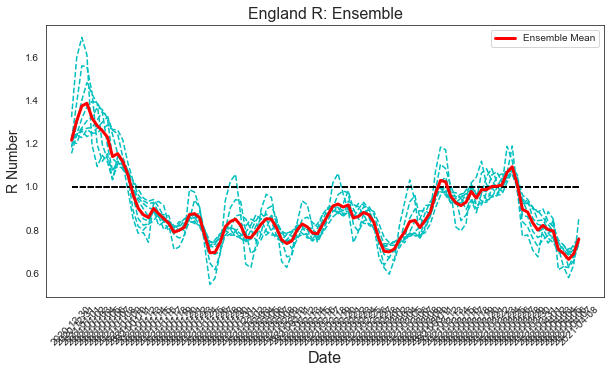

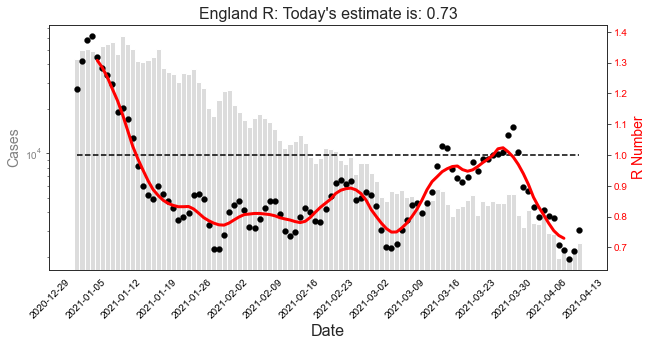

[1.21503727 1.30505418 1.37368825 1.38624279 1.31752987 1.28262478
 1.259172   1.22978439 1.13948789 1.15300643 1.11663596 1.05534529
 0.96403012 0.89985414 0.87028923 0.85683506 0.89950399 0.87470957
 0.85161655 0.82960548 0.78928408 0.79791808 0.81179939 0.87031142
 0.87506799 0.85644907 0.77300539 0.69384999 0.69581221 0.74137818
 0.814552   0.8386087  0.84946024 0.82130375 0.76636959 0.76368384
 0.79319707 0.82674967 0.85155685 0.84942989 0.80884708 0.7534364
 0.73675019 0.74884136 0.79856524 0.82737751 0.81399117 0.78586797
 0.78205591 0.82587346 0.86769716 0.91011498 0.91963445 0.90582145
 0.91532787 0.85514171 0.86204663 0.88058416 0.87003301 0.83507572
 0.75617509 0.70104647 0.69817063 0.7114321  0.7561004  0.79025265
 0.83827939 0.84396565 0.81053867 0.84469922 0.88000681 0.9654079
 1.02896517 1.02275236 0.95580235 0.92525829 0.91255573 0.92832464
 0.97775038 0.9468205  0.98603355 0.98640718 1.00086665 1.00191849
 1.00848614 1.06674866 1.09246501 1.00912542 0.89470153 0.882713

In [18]:
#plot_ensemble_graph(Number_of_Days, Location, Area_Type, Data_Type, Lowest RCL, Highest RCL + 1, Weight, X, Y))
#RCL is the length of time you draw the trendline to calculate R over
#max Number_of_Days for England is 295 + number of days into 2021, using Highest RCL = 15 (I think)
plot_ensemble_graph(100, 'England', 'nation', 7, 15, 1, 10, 5)
